# preproc data

In [1]:
import os
import pandas as pd
import torch
from torchvision import transforms
from utils import DRDataset
from sklearn.model_selection import train_test_split
import numpy as np

preproc = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

DESC = 'baseline'
if not os.path.exists(f'../results/{DESC}'):
    os.makedirs(f'../results/{DESC}')
    
#load labels
labels = pd.read_csv('../data/trainLabels.csv')

NUM_CLASSES = len(labels['level'].unique())
LABELS_MAP = ['0-No DR', '1-Mild', '2-Moderate', '3-Severe', '4-Proliferative DR']
BATCH_SIZE = 32

# split into train/val/test using stratified sampling (70/10/20)
# TODO --> use torch to split all at once?
labels_train, labels_test = train_test_split(labels, test_size=0.3, stratify=labels['level'])
labels_val, labels_test = train_test_split(labels_test, test_size=2/3, stratify=labels_test['level'])

# Create dataset objects using the resampled labels
train_data = DRDataset(labels_train, '../data/preproc_train_imgs.pt', preproc=preproc)
val_data = DRDataset(labels_val, '../data/preproc_train_imgs.pt', preproc=preproc)
test_data = DRDataset(labels_test, '../data/preproc_train_imgs.pt', preproc=preproc)

#Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

#dataset size checks
train_N = len(train_loader.dataset)
val_N = len(val_loader.dataset)
test_N = len(test_loader.dataset)

train_N, val_N, test_N

(24588, 3512, 7026)

# model

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class baseline_cnn(nn.Module):
    def __init__(self, num_classes=5):  # 5 DR classes: 0 to 4
        super(baseline_cnn, self).__init__()
        
        # Input: (3, 224, 224)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # -> (32, 224, 224)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # -> (64, 112, 112)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces dims by 2
        self.dropout = nn.Dropout(0.25)

        # After 2 poolings: 224 -> 112 -> 56
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # (32, 224, 224)
        x = self.pool(x)           # (32, 112, 112)
        
        x = F.relu(self.conv2(x))  # (64, 112, 112)
        x = self.pool(x)           # (64, 56, 56)
        
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

baseline_model = baseline_cnn(num_classes=NUM_CLASSES)

# print model summary
summary(baseline_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
baseline_cnn                             [1, 5]                    --
├─Conv2d: 1-1                            [1, 32, 224, 224]         896
├─MaxPool2d: 1-2                         [1, 32, 112, 112]         --
├─Conv2d: 1-3                            [1, 64, 112, 112]         18,496
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Dropout: 1-5                           [1, 64, 56, 56]           --
├─Linear: 1-6                            [1, 512]                  102,760,960
├─Dropout: 1-7                           [1, 512]                  --
├─Linear: 1-8                            [1, 5]                    2,565
Total params: 102,782,917
Trainable params: 102,782,917
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 379.74
Input size (MB): 0.60
Forward/backward pass size (MB): 19.27
Params size (MB): 411.13
Estimated Total Size (MB): 431.01

In [3]:
# compile model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_model.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss() # expects logits
optimizer = torch.optim.Adam(baseline_model.parameters())

# train
EPOCHS = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = torch.inf
for epoch in range(EPOCHS):
    # train
    baseline_model.train()
    running_loss = 0.0
    running_correct = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = baseline_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_correct += (torch.softmax(outputs, dim=1).argmax(dim=1) == labels).sum().item()

    # val
    baseline_model.eval()
    running_vloss = 0.0
    running_vcorrect = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = baseline_model(inputs)
            vloss = loss_fn(outputs, labels)
            running_vloss += vloss.item()
            running_vcorrect += (torch.softmax(outputs, dim=1).argmax(dim=1) == labels).sum().item()

    print(f"Epoch {epoch+1}/{EPOCHS}\t" +
          f"Train Loss: {running_loss/train_N:.4f} | Train Acc: {running_correct/train_N:.4f} | " +
          f"Val Loss: {running_vloss/val_N:.4f} | Val Acc: {running_vcorrect/val_N:.4f}")

    train_losses.append(running_loss/train_N)
    val_losses.append(running_vloss/val_N)
    train_accs.append(running_correct/train_N)
    val_accs.append(running_vcorrect/val_N)

    # save best model
    if running_vloss < best_val_loss:
        best_val_loss = running_vloss
        torch.save(baseline_model, f'../results/{DESC}/model.pth')

# evaluate
# load best model
baseline_model = torch.load(f'../results/{DESC}/model.pth', weights_only=False).to(DEVICE)
baseline_model.eval()
correct = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = baseline_model(inputs)
        correct += (torch.softmax(outputs, dim=1).argmax(dim=1) == labels).sum().item()
print()
print(f'Test Accuracy: {correct/test_N:.4f}')

Epoch 1/100	Train Loss: 0.0320 | Train Acc: 0.7320 | Val Loss: 0.0273 | Val Acc: 0.7349
Epoch 2/100	Train Loss: 0.0271 | Train Acc: 0.7348 | Val Loss: 0.0267 | Val Acc: 0.7349
Epoch 3/100	Train Loss: 0.0267 | Train Acc: 0.7348 | Val Loss: 0.0267 | Val Acc: 0.7349
Epoch 4/100	Train Loss: 0.0265 | Train Acc: 0.7348 | Val Loss: 0.0263 | Val Acc: 0.7349
Epoch 5/100	Train Loss: 0.0262 | Train Acc: 0.7348 | Val Loss: 0.0264 | Val Acc: 0.7349
Epoch 6/100	Train Loss: 0.0256 | Train Acc: 0.7348 | Val Loss: 0.0263 | Val Acc: 0.7349
Epoch 7/100	Train Loss: 0.0248 | Train Acc: 0.7353 | Val Loss: 0.0265 | Val Acc: 0.7349
Epoch 8/100	Train Loss: 0.0234 | Train Acc: 0.7397 | Val Loss: 0.0273 | Val Acc: 0.7355
Epoch 9/100	Train Loss: 0.0209 | Train Acc: 0.7581 | Val Loss: 0.0289 | Val Acc: 0.7306
Epoch 10/100	Train Loss: 0.0183 | Train Acc: 0.7847 | Val Loss: 0.0328 | Val Acc: 0.7161
Epoch 11/100	Train Loss: 0.0151 | Train Acc: 0.8213 | Val Loss: 0.0349 | Val Acc: 0.7215
Epoch 12/100	Train Loss: 0.012

In [4]:
# save datasets, optimizer state, and metrics to metadata file
torch.save({'train_data': train_data,
            'val_data': val_data,
            'test_data': test_data,
            'optimizer_state': optimizer.state_dict(),
            'metrics': pd.DataFrame({'train_loss': train_losses,
                                     'val_loss': val_losses,
                                     'train_acc': train_accs,
                                     'val_acc': val_accs})},
            
            f'../results/{DESC}/metadata.pth')

# training curves

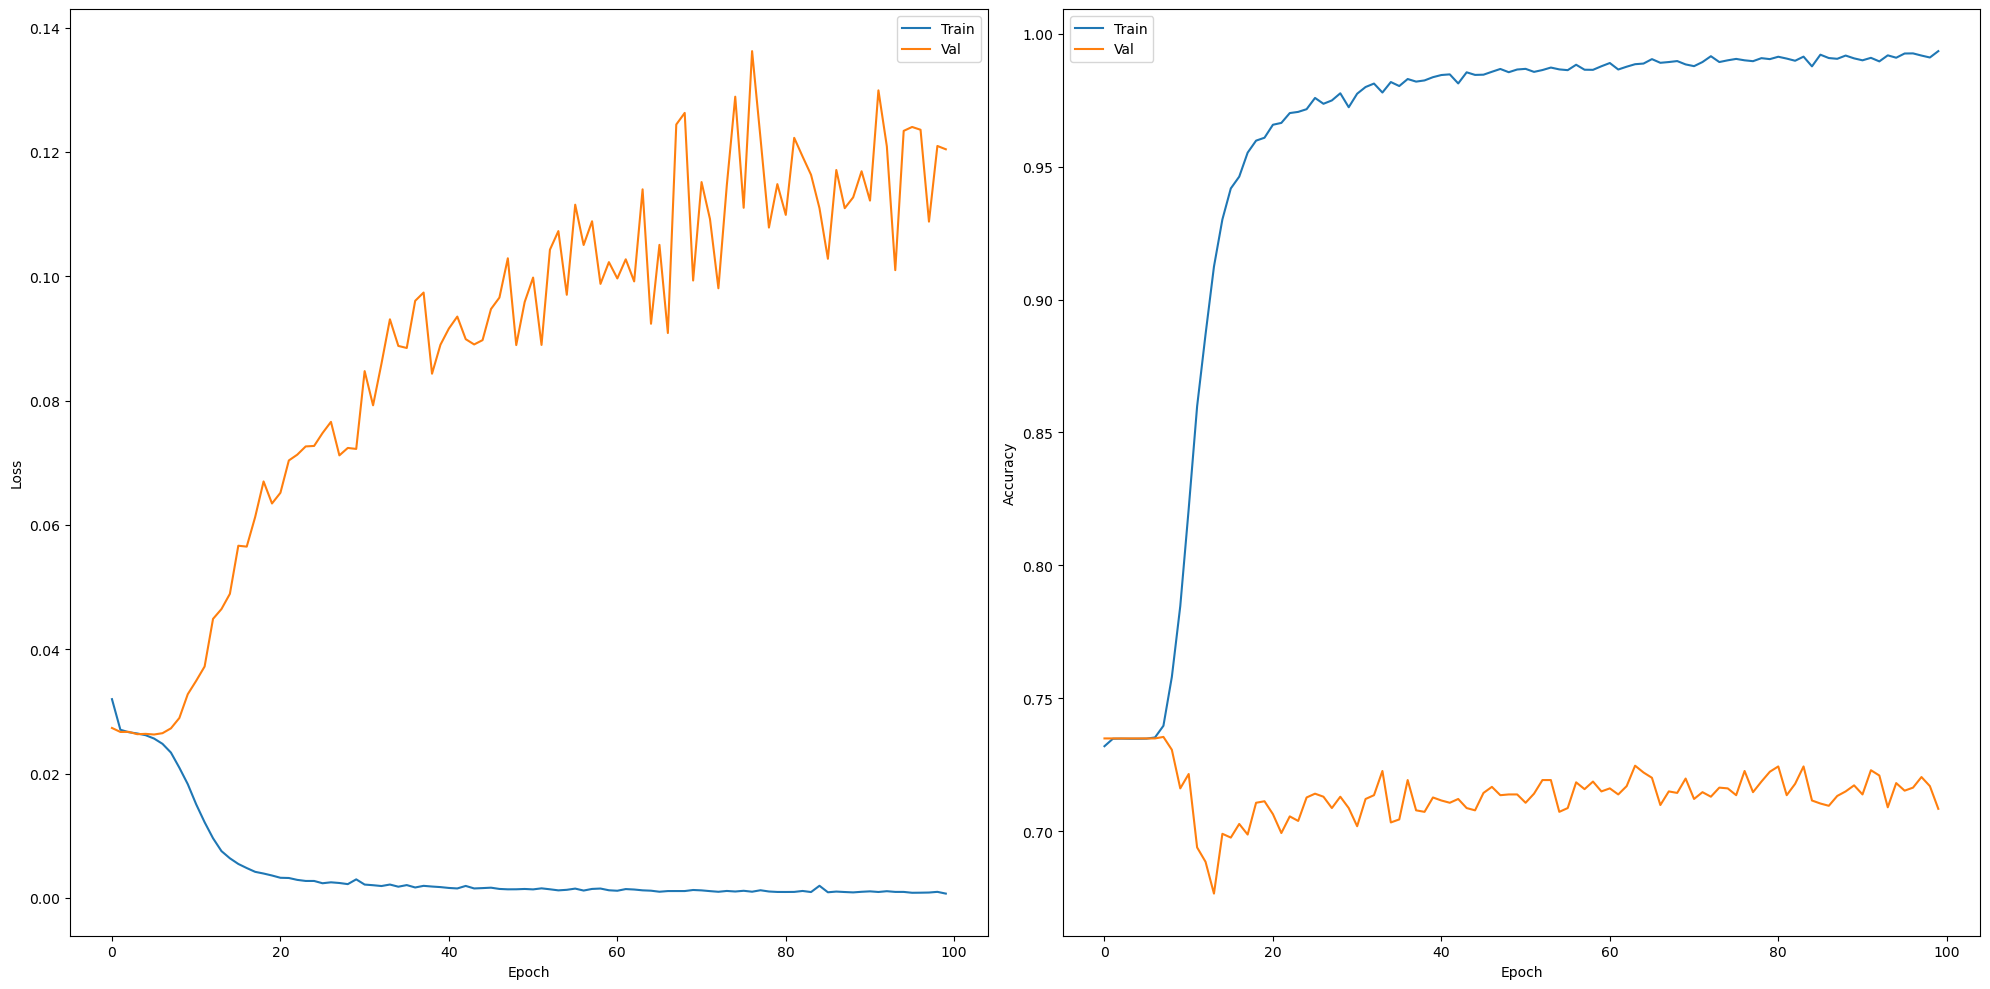

In [5]:
# plot training curves
import matplotlib.pyplot as plt

# losses
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(f'../results/{DESC}/training_curves_{EPOCHS}epochs.png')
plt.show()

# confusion matrix

In [6]:
# test set results (~15min/1s if images are loaded/not loaded in memory)
baseline_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = baseline_model(inputs)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(torch.softmax(outputs, dim=1).argmax(dim=1).cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
np.savez(f'../results/{DESC}/test_results.npz', y_true=y_true, y_pred=y_pred)

                    precision    recall  f1-score   support

           0-No DR       0.74      1.00      0.85      5162
            1-Mild       0.00      0.00      0.00       489
        2-Moderate       0.33      0.00      0.00      1059
          3-Severe       0.00      0.00      0.00       175
4-Proliferative DR       0.00      0.00      0.00       141

          accuracy                           0.73      7026
         macro avg       0.21      0.20      0.17      7026
      weighted avg       0.59      0.73      0.62      7026



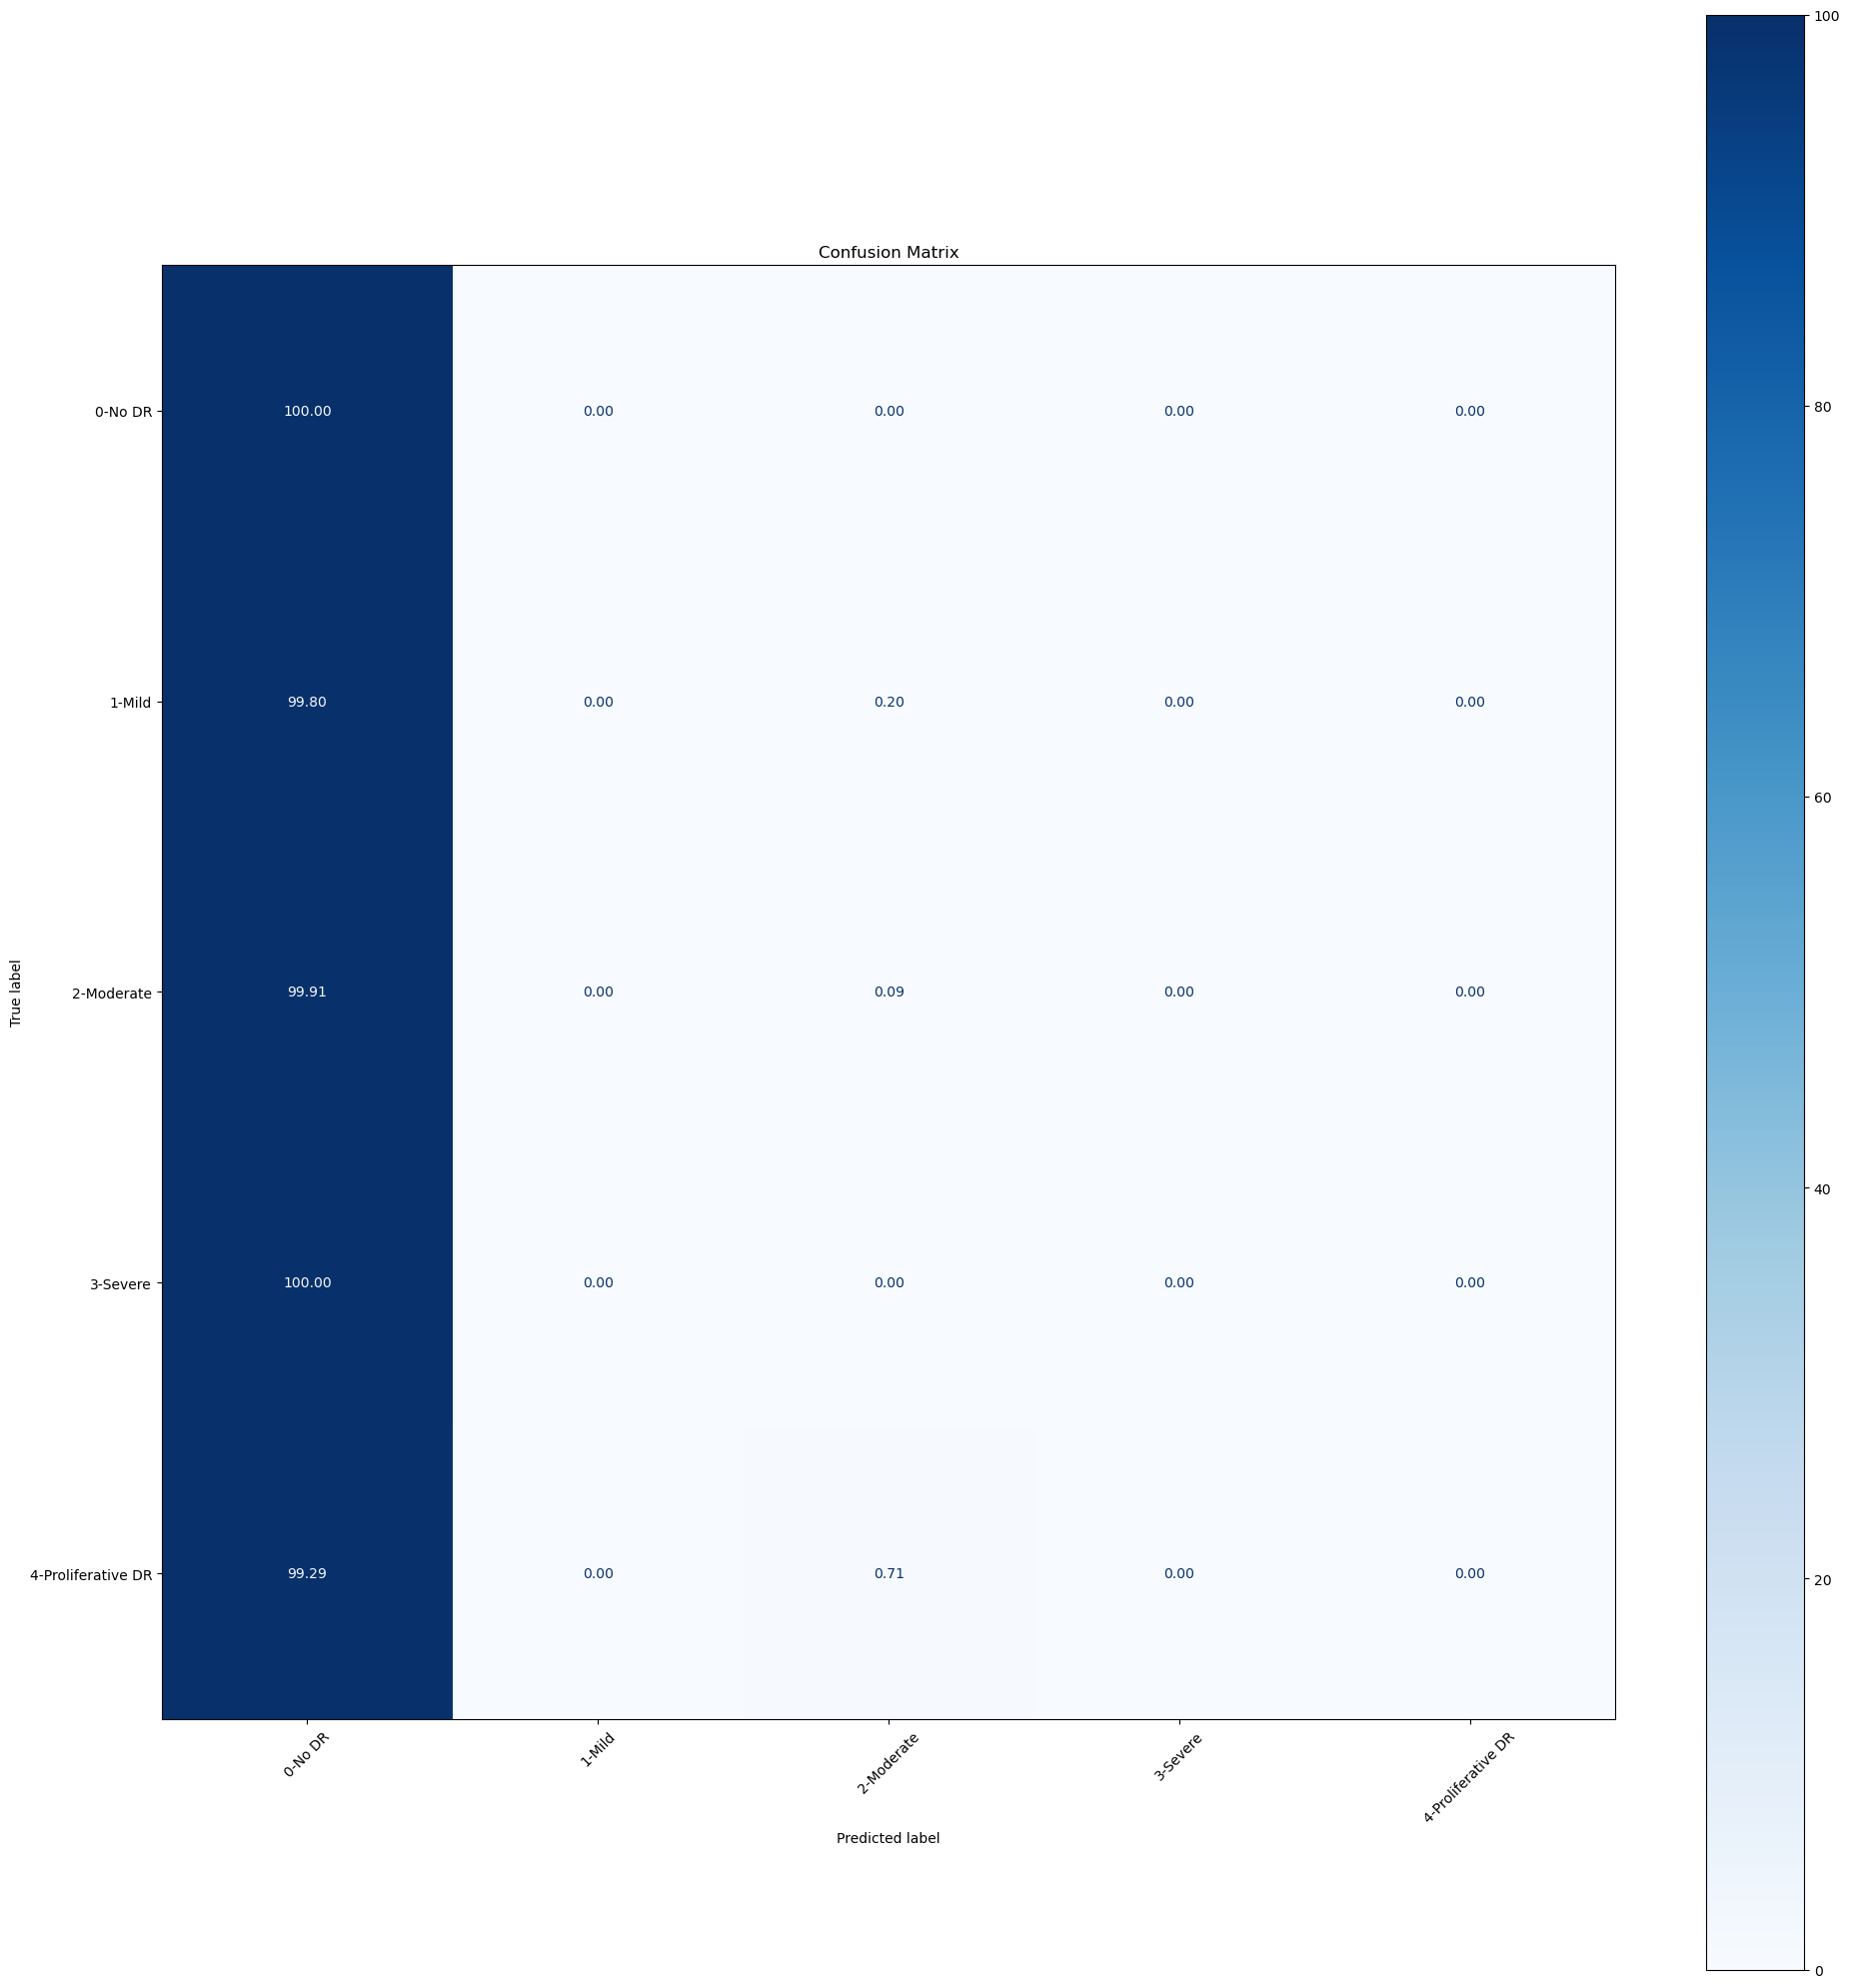

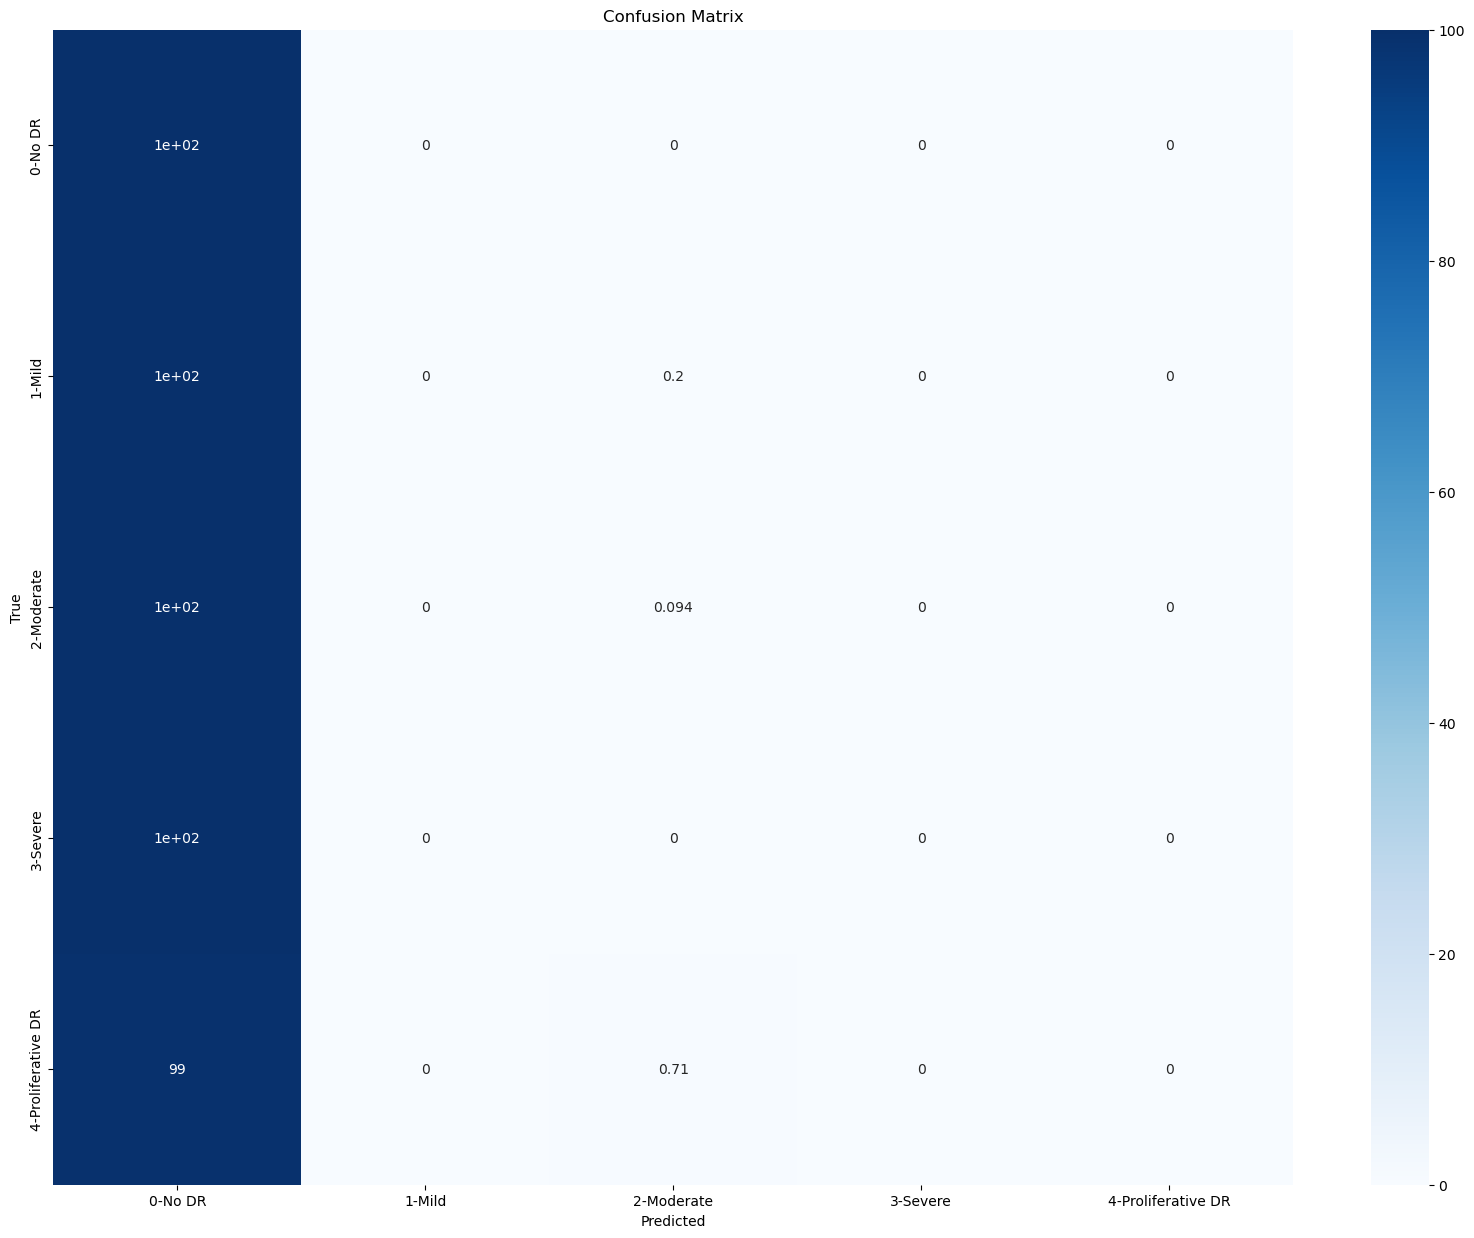

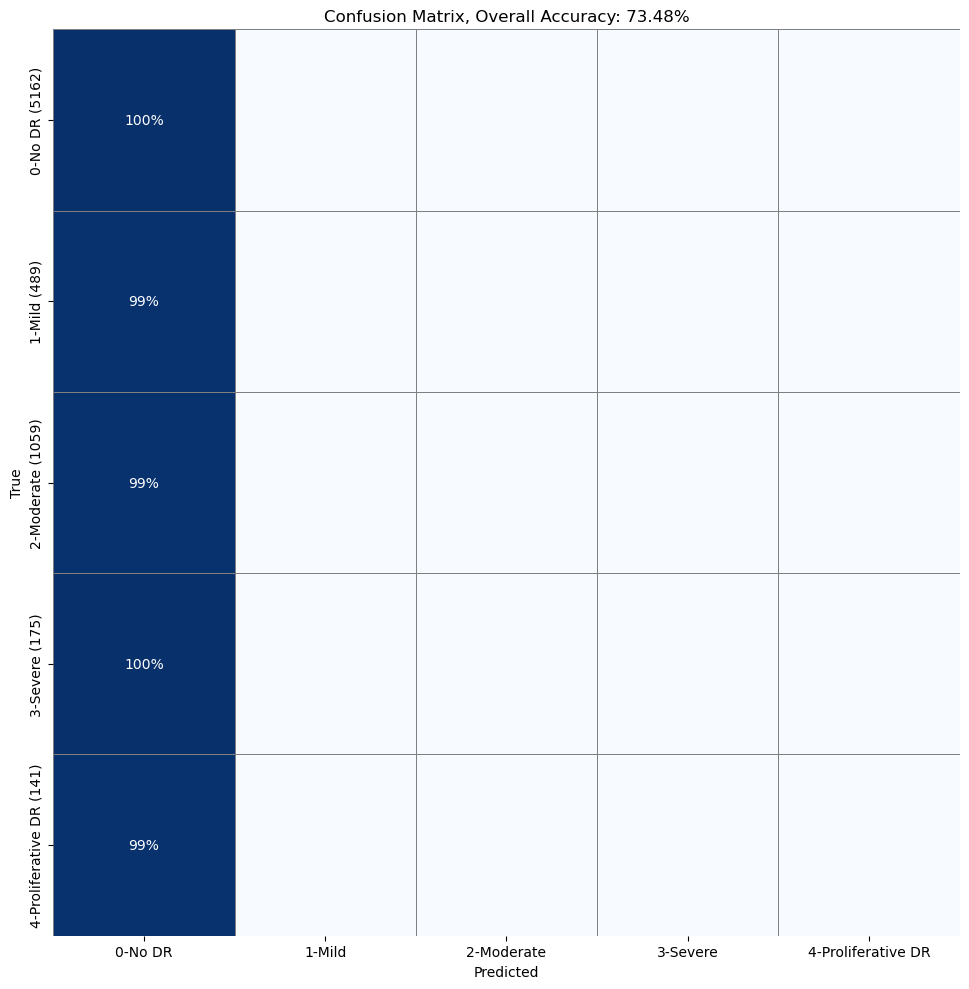

In [7]:
# TODO: clean this up

'''
CLASSIFICATION REPORT AND CONFUSIONMATRIXDISPLAY
'''
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
print(classification_report(y_true, y_pred, labels=range(NUM_CLASSES), target_names=LABELS_MAP, zero_division=0))

cm = 100*confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS_MAP)
# plot on large figure
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(xticks_rotation = 45, values_format = '.2f', ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

'''
SIMPLE CONFUSION MATRIX
'''
# confusion matrix for test set
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# simple
cm = 100*confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, cmap='Blues',
            xticklabels=LABELS_MAP,
            yticklabels=LABELS_MAP)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

'''
CLEARER CONFUSION MATRIX (saved)
'''
# Compute normalized confusion matrix (row-wise normalization)
cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')

# Convert to integer percentages (whole numbers for clarity)
cm_percent = (cm * 100).astype(int)

# Get the number of true labels per class
true_counts = np.bincount(y_true, minlength=NUM_CLASSES)

# Create annotation labels: format as integer percentages, hide 0%
annot_labels = np.empty_like(cm_percent, dtype=object)
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        if cm_percent[i, j] > 0:
            annot_labels[i, j] = f"{cm_percent[i, j]}%"  # No decimals
        else:
            annot_labels[i, j] = ""

# Modify y-tick labels to include true label counts
class_labels = LABELS_MAP
yticklabels_with_counts = [f"{label} ({true_counts[i]})" for i, label in enumerate(class_labels)]

# Plot the heatmap in YOLO style
plt.figure(figsize=(12, 10))  # Adjust figure size for readability
sns.heatmap(cm_percent, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=yticklabels_with_counts,  # Updated y-tick labels
            linewidths=0.5, linecolor='gray', square=True, cbar=False)  # Clean grid layout

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix, Overall Accuracy: {100*correct/test_N:.2f}%')
plt.tight_layout()
plt.savefig(f'../results/{DESC}/confusion_matrix_{EPOCHS}epochs.png')
plt.show()